In [1]:
#if you have not installed tabulate 
#this is just for printing the information of data in a prettier format
! pip install tabulate

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Testing Function

In [2]:
#import main code
from OurTrainingTools import *
#this will throw a random number and print it
#to reset the random number manually, use
#torch.manual_seed(random_seed)


def test_model(madminermodel, test_input_sm, test_input_bsm, bsmparval, NSM, NBSM, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        # computing test statistics t (or lambda) in equation (2) of paper
        def compute_t(madminermodel, nev, counter, test_input):
            # generate number of points for testing under Poisson distribution
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            # stop if there are no more points to test
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            
            # compute test statistics
            log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                            np.array([0.]), np.array([bsmparval,]))[0][0])
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            
            #return test statistics and the starting point for the next batch
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        # empty array to store values
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        #compute mean and variation of the test statistics in two hypotheses
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        #compute separation and p-value
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        results_path = os.getcwd()
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = '/toydata/madminer-carl-'+title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return sep, p

=========== Random Seed: 944 ===========


In [3]:
#import main code
from OurTrainingTools import *
#this will throw a random number and print it
#to reset the random number manually, use
#torch.manual_seed(random_seed)


def test_model_qc(model, test_input_sm, test_input_bsm, bsmparval, NSM, NBSM, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        # computing test statistics t (or lambda) in equation (2) of paper
        def compute_t(model, nev, counter, test_input):
            # generate number of points for testing under Poisson distribution
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            # stop if there are no more points to test
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            
            # compute test statistics
            #print(points)
            y = model.Forward(points, np.ones(len(points))*bsmparval).detach()
            log_ratio = np.log(y/(1.-y))
            #calculate_ratio
            #log_ratio = torch.tensor(log_ratio)
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            
            #return test statistics and the starting point for the next batch
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        # empty array to store values
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(model, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(model, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        #compute mean and variation of the test statistics in two hypotheses
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        #compute separation and p-value
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        results_path = os.getcwd()
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return sep, p

In [4]:
def combine_pm(tsm_plus, tbsm_plus, tsm_minus, tbsm_minus, e):
    len_sm    = min(len(tsm_plus), len(tsm_minus))
    len_bsm   = min(len(tbsm_plus), len(tbsm_minus))
    
    tsm       = (tsm_plus[:len_sm] + tsm_minus[:len_sm])
    tbsm      = (tbsm_plus[:len_bsm] + tbsm_minus[:len_bsm])
    
    mu_sm     = tsm.mean().item()
    mu_bsm    = tbsm.mean().item()
    sigma_sm  = tsm.std().item()
    sigma_bsm = tbsm.std().item()
    med_sm    = tsm.median().item()
    
    sep    = (mu_sm - mu_bsm)/sigma_bsm
    p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm)
    
    delta1 = (p * (1 - p)/min(len_sm, len_bsm))**0.5
    delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
            2 * sigma_bsm**2))/(2*(n_meas**0.5))
    deltap = (delta1**2 + delta2**2)**0.5
    
    title = '%s, %s%s, combined, %s, N=%d, epochs=%d'%(
                     outputheader, str(n_neurons), bsm_op, bsm_test, N, e)

    simpleplot(tsm, tbsm, title, sep, p, deltap)
    
    return (p, deltap)

In [5]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    
    return

In [14]:
def TestEstimator(estimator, gphival, gphival_name='', withXS=True, title_message='', qc=False):
    
    #toy data file path
    f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%s.h5'%(gphival_name), 'r')

    #parse data 
    Data = np.array(f['Data'])
    Labels = np.array(f['Labels'])
    NSM = np.array(f['NSM'])
    
    
    if withXS:
        NBSMList = np.array(f['NBSMList'])
        NBSM = NBSMList[0]
    else:
        NBSM = NSM
        
    #randomise
    Idx_test = torch.randperm(len(Data))
    Data_test = torch.Tensor(Data[Idx_test])
    Label_test = torch.Tensor(Labels[Idx_test])

    #print(Data.mean(0), Data.std(0))
    
    #select data from each hypothesis
    SM_Data  = Data_test[Label_test==0, :]
    BSM_Data = Data_test[Label_test==1, :]

    #for plotting/ printing
    #n_epochs = current_epoch = int(1e4)
    n_epochs = int(1e4)
    current_epoch = 0
    results_path = os.getcwd()
    charge = 'plus'

    #number of tests thrown on the data
    #the test function will stop automatically if points run out
    n_meas = 4000

    if withXS:
        if not qc:
            sep, p = test_model(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
                  verbose_t=True, verbose_period_t=1e5, title='gphi%s'%(gphival_name)+title_message)
        else:
            sep, p = test_model_qc(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
                  verbose_t=True, verbose_period_t=1e5, title='gphi%s'%(gphival_name)+title_message)
    else:
        if not qc:
            sep, p = test_model(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='gphi%s_equalXS'%(gphival_name)+title_message)
        else:
            sep, p = test_model_qc(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='gphi%s_equalXS'%(gphival_name)+title_message)
        
        
    f.close()
    return sep, p

## Reading Model

In [15]:
estimator = OurModel(AR=[9, 32, 32, 32, 32, 1])
estimator.Load_CPU('cpu_model', os.getcwd()+'/models/')

Model successfully loaded.
Path: /madminer/madminer/examples/tutorial_particle_physics/models/cpu_model.pth


In [16]:
gphivals = [0.0035, 0.004, 0.005, 0.006, 0.05, 0.2, 0.5]
gphival_names = ['35e-4_out', '4e-3_out', '5e-3_out', '6e-3_out', '5e-2_in', '2e-1_in', '5e-1_in']

NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = -64.580,  tbsm = -70.273
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.018, delta2 = 0.012
p = 0.073 +/- 0.021
Separation = 1.39 sigmas


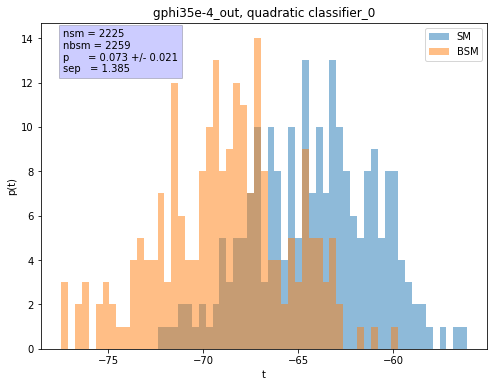

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2263.789
test 0   : tsm = -65.810,  tbsm = -76.770
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.018, delta2 = 0.012
p = 0.073 +/- 0.021
Separation = 1.41 sigmas


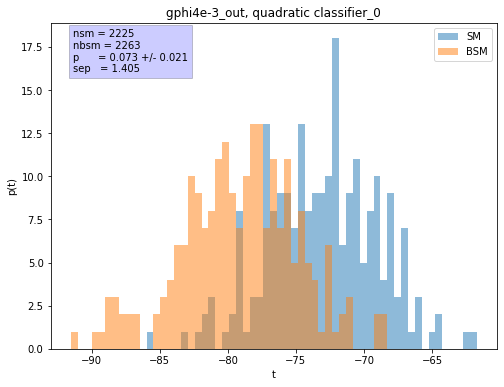

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = -91.222,  tbsm = -98.639
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.011, delta2 = 0.007
p = 0.027 +/- 0.013
Separation = 1.72 sigmas


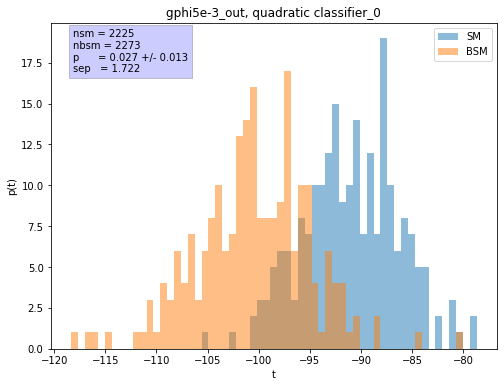

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2284.042
test 0   : tsm = -109.125,  tbsm = -114.044
Reaching the end of test data. Stop tests at 218. 
===> delta1 = 0.000, delta2 = 0.003
p = 0.000 +/- 0.003
Separation = 2.18 sigmas


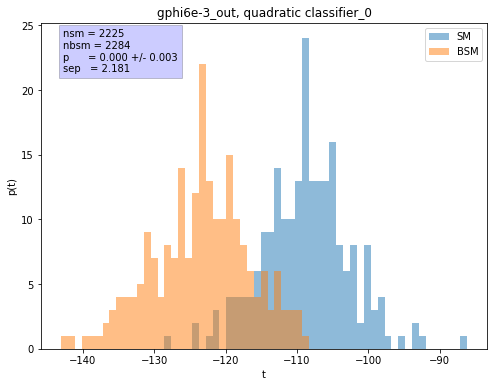

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -779.941,  tbsm = -2058.374
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 15.64 sigmas


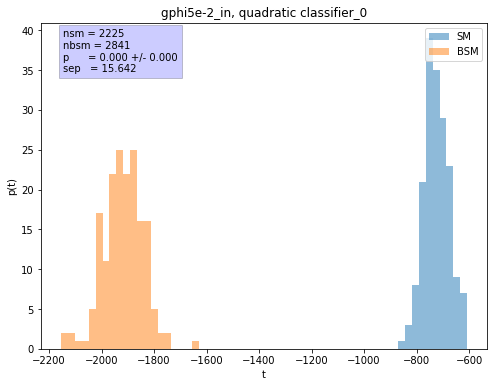

Partial test after 0 epochs (took 0.79 seconds)

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 945.861,  tbsm = -27148.766
Reaching the end of test data. Stop tests at 77. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 59.56 sigmas


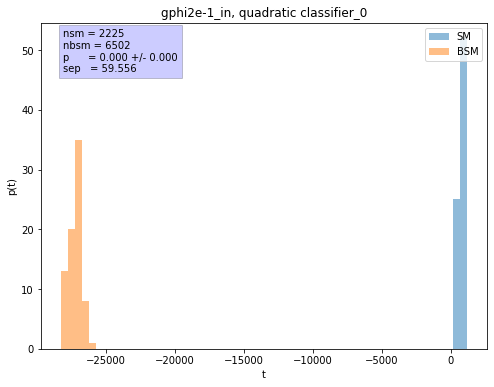

Partial test after 0 epochs (took 0.39 seconds)

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 23004.254,  tbsm = -214105.594
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 193.57 sigmas


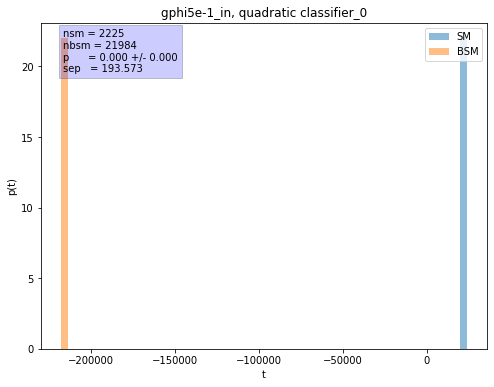

Partial test after 0 epochs (took 0.18 seconds)

NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = -64.147,  tbsm = -69.981
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.021, delta2 = 0.016
p = 0.104 +/- 0.026
Separation = 1.22 sigmas


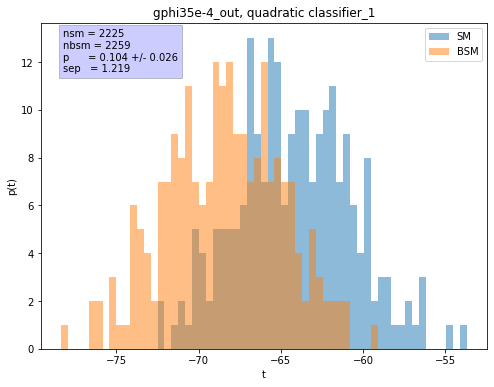

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2263.789
test 0   : tsm = -69.336,  tbsm = -76.670
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.015, delta2 = 0.009
p = 0.055 +/- 0.018
Separation = 1.49 sigmas


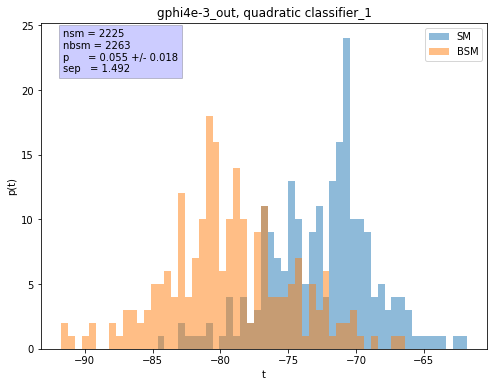

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = -98.170,  tbsm = -101.835
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.013, delta2 = 0.006
p = 0.037 +/- 0.014
Separation = 1.77 sigmas


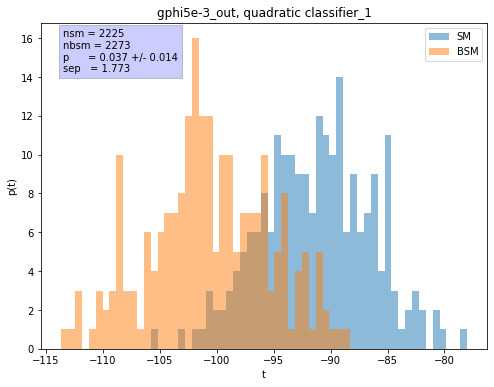

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2284.042
test 0   : tsm = -111.910,  tbsm = -126.865
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.000, delta2 = 0.003
p = 0.000 +/- 0.003
Separation = 2.27 sigmas


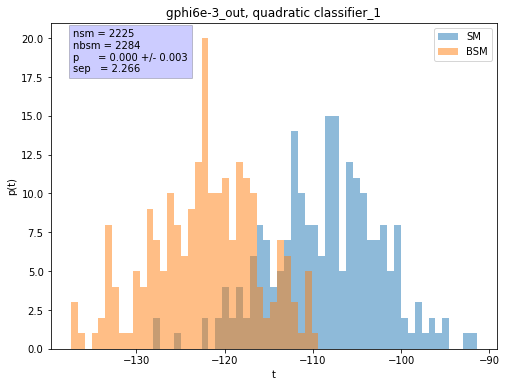

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -720.428,  tbsm = -1979.120
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 15.68 sigmas


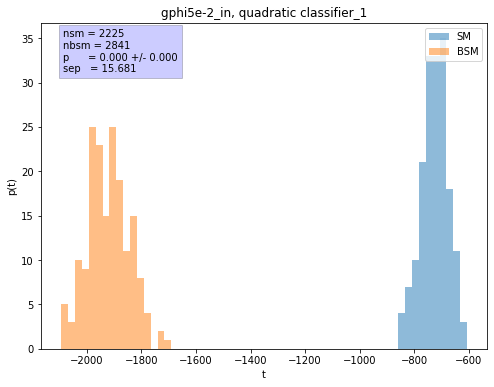

Partial test after 0 epochs (took 0.78 seconds)

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 605.955,  tbsm = -27828.713
Reaching the end of test data. Stop tests at 76. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 52.13 sigmas


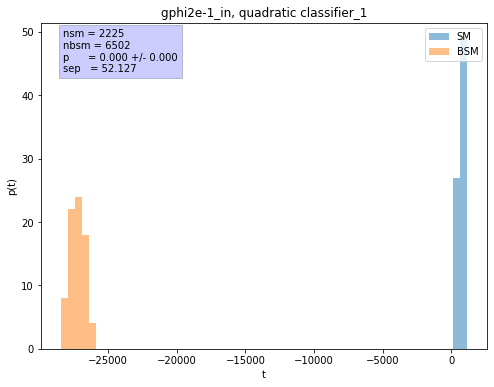

Partial test after 0 epochs (took 0.38 seconds)

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 23663.195,  tbsm = -212176.422
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 126.72 sigmas


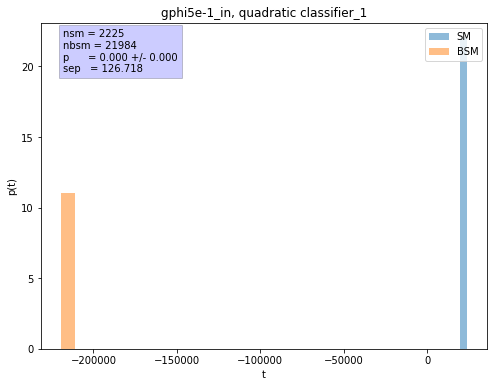

Partial test after 0 epochs (took 0.18 seconds)

NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = -60.024,  tbsm = -69.098
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.018, delta2 = 0.013
p = 0.081 +/- 0.022
Separation = 1.37 sigmas


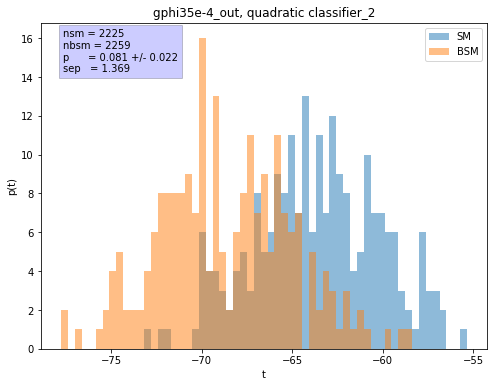

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2263.789
test 0   : tsm = -68.542,  tbsm = -87.268
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.015, delta2 = 0.011
p = 0.055 +/- 0.019
Separation = 1.51 sigmas


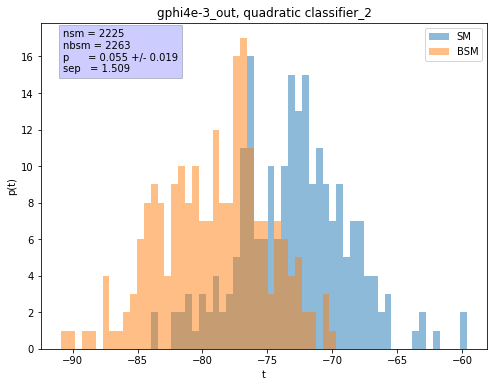

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = -78.896,  tbsm = -104.373
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.012, delta2 = 0.006
p = 0.032 +/- 0.013
Separation = 1.75 sigmas


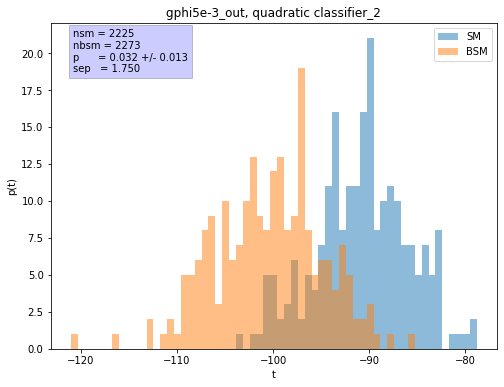

Partial test after 0 epochs (took 0.93 seconds)

NSM = 2225.504 --- NBSM = 2284.042
test 0   : tsm = -109.463,  tbsm = -109.052
Reaching the end of test data. Stop tests at 218. 
===> delta1 = 0.011, delta2 = 0.004
p = 0.028 +/- 0.012
Separation = 2.03 sigmas


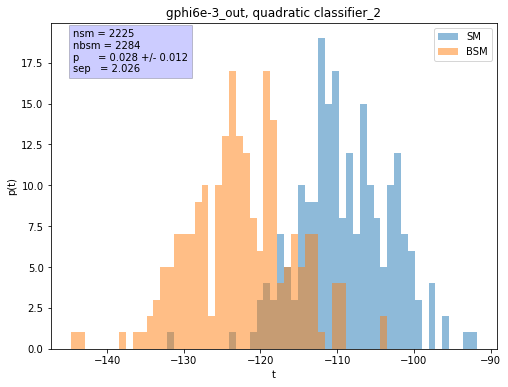

Partial test after 0 epochs (took 0.93 seconds)

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -737.843,  tbsm = -2051.958
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 15.97 sigmas


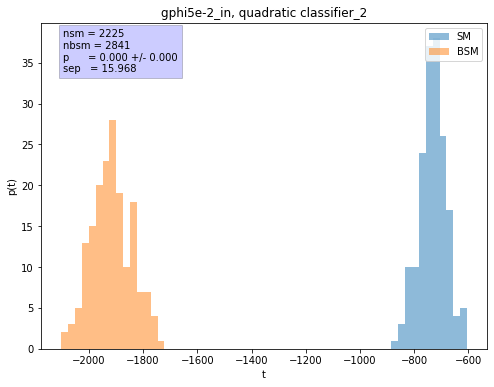

Partial test after 0 epochs (took 0.79 seconds)

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 986.971,  tbsm = -26434.008
Reaching the end of test data. Stop tests at 76. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 51.92 sigmas


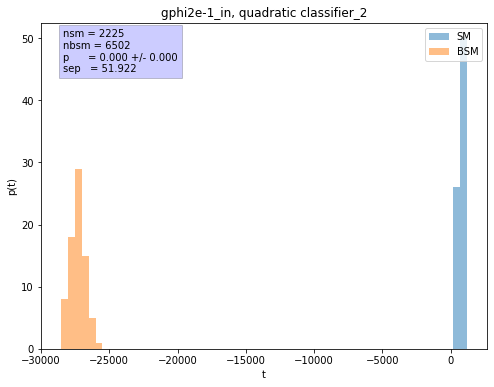

Partial test after 0 epochs (took 0.39 seconds)

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 23657.594,  tbsm = -214713.781
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 122.40 sigmas


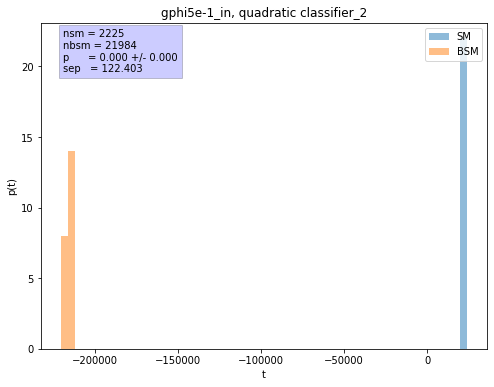

Partial test after 0 epochs (took 0.18 seconds)

NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = -69.233,  tbsm = -68.096
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.019, delta2 = 0.014
p = 0.090 +/- 0.024
Separation = 1.26 sigmas


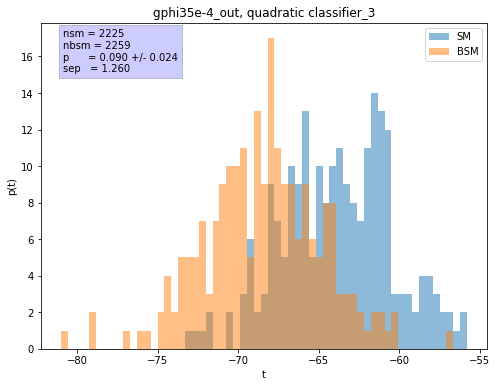

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2263.789
test 0   : tsm = -71.491,  tbsm = -78.608
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.012, delta2 = 0.010
p = 0.032 +/- 0.016
Separation = 1.52 sigmas


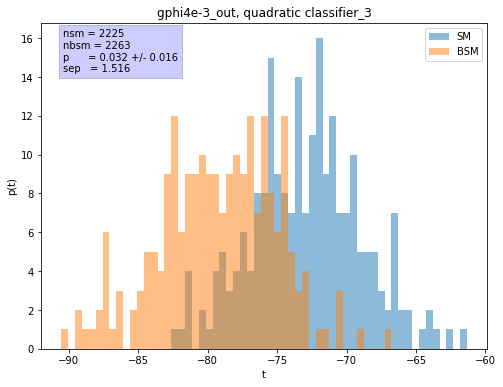

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = -89.398,  tbsm = -93.529
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.008, delta2 = 0.005
p = 0.014 +/- 0.009
Separation = 2.03 sigmas


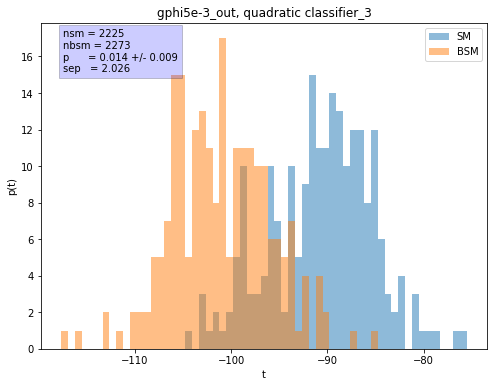

Partial test after 0 epochs (took 0.93 seconds)

NSM = 2225.504 --- NBSM = 2284.042
test 0   : tsm = -113.862,  tbsm = -116.730
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.009, delta2 = 0.004
p = 0.018 +/- 0.010
Separation = 1.98 sigmas


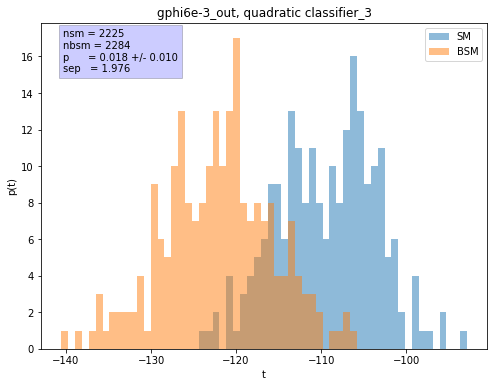

Partial test after 0 epochs (took 0.94 seconds)

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -718.816,  tbsm = -2097.621
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 16.76 sigmas


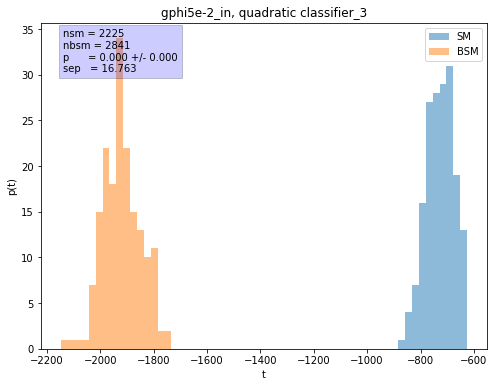

Partial test after 0 epochs (took 0.79 seconds)

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 609.671,  tbsm = -26523.127
Reaching the end of test data. Stop tests at 76. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 54.47 sigmas


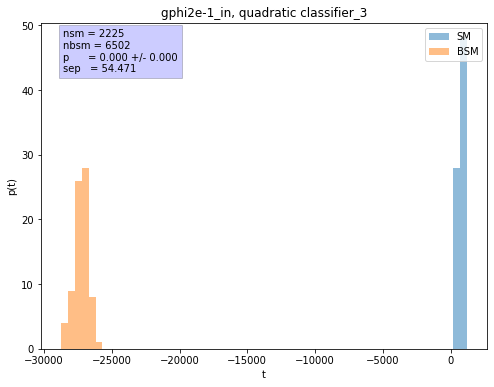

Partial test after 0 epochs (took 0.43 seconds)

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 23024.754,  tbsm = -216080.688
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 161.67 sigmas


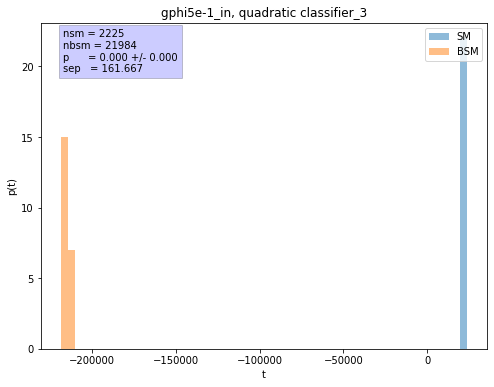

Partial test after 0 epochs (took 0.18 seconds)

NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = -63.772,  tbsm = -68.496
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.022, delta2 = 0.014
p = 0.123 +/- 0.026
Separation = 1.32 sigmas


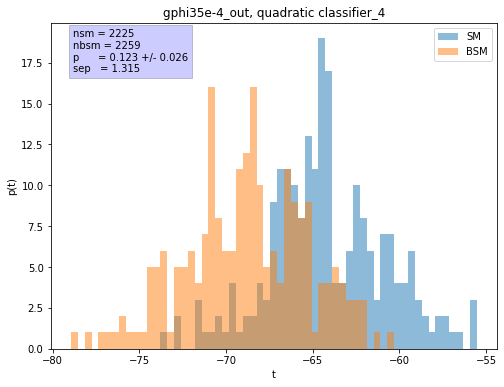

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2263.789
test 0   : tsm = -69.459,  tbsm = -76.467
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.018, delta2 = 0.011
p = 0.073 +/- 0.021
Separation = 1.39 sigmas


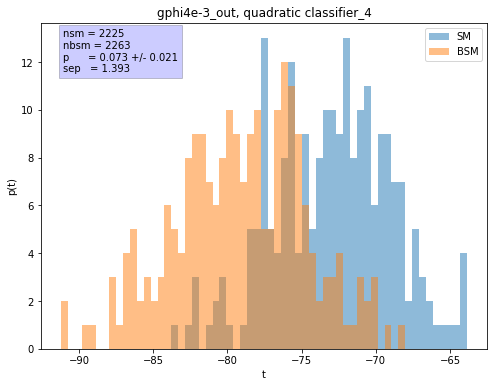

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = -90.720,  tbsm = -101.755
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.014, delta2 = 0.006
p = 0.045 +/- 0.015
Separation = 1.81 sigmas


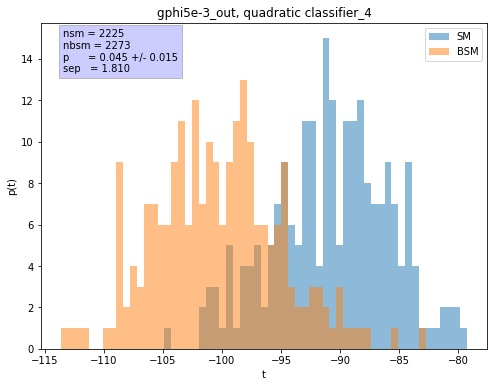

Partial test after 0 epochs (took 0.95 seconds)

NSM = 2225.504 --- NBSM = 2284.042
test 0   : tsm = -107.248,  tbsm = -121.282
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.005, delta2 = 0.002
p = 0.005 +/- 0.005
Separation = 2.29 sigmas


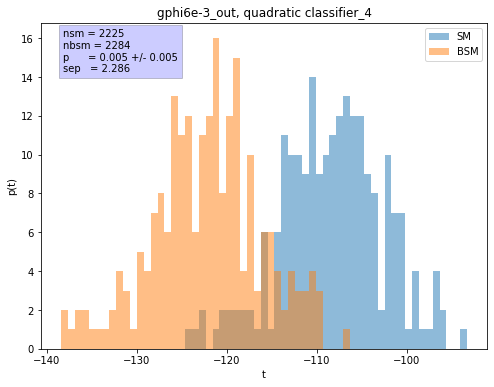

Partial test after 0 epochs (took 0.97 seconds)

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -749.410,  tbsm = -1946.385
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 15.26 sigmas


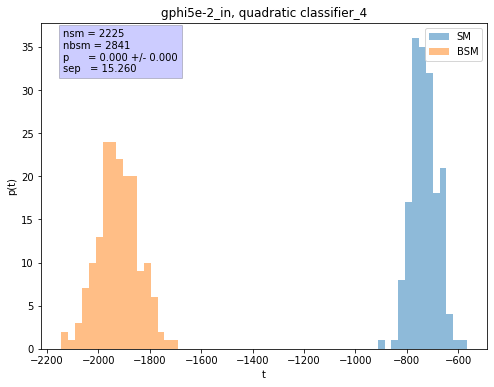

Partial test after 0 epochs (took 0.79 seconds)

NSM = 2225.504 --- NBSM = 6502.484
test 0   : tsm = 546.050,  tbsm = -27311.904
Reaching the end of test data. Stop tests at 76. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 55.45 sigmas


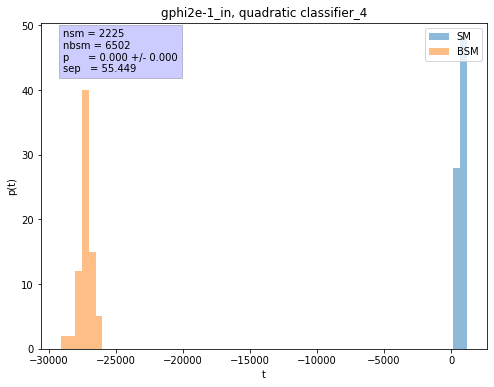

Partial test after 0 epochs (took 0.39 seconds)

NSM = 2225.504 --- NBSM = 21984.864
test 0   : tsm = 23426.529,  tbsm = -213899.375
Reaching the end of test data. Stop tests at 22. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 136.21 sigmas


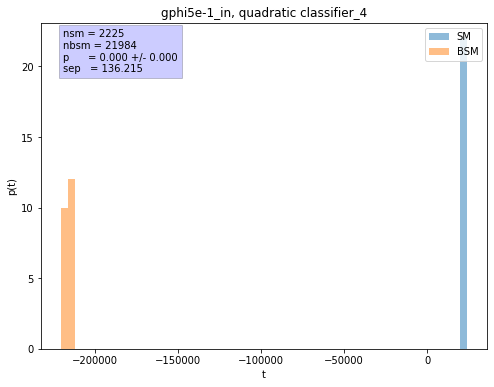

Partial test after 0 epochs (took 0.18 seconds)



In [17]:
total_seps, total_ps = [], []
for i in range(5):
    seps, ps = [], []
    for gphival, gphival_name in zip(gphivals, gphival_names):
        sep, p = TestEstimator(estimator, gphival, gphival_name, title_message=', quadratic classifier_%d'%i, qc=True)
        seps.append(sep)
        ps.append(p)
    total_seps.append(seps)
    total_ps.append(ps)
    
final_sep = torch.Tensor(total_seps).mean(0)
fianl_p = torch.Tensor(total_ps).mean(0)

In [18]:
fianl_p, final_sep

(tensor([0.0943, 0.0573, 0.0310, 0.0101, 0.0000, 0.0000, 0.0000]),
 tensor([  1.3097,   1.4629,   1.8162,   2.1471,  15.8628,  54.7048, 148.1150]))

Evaluating with knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = 202.433,  tbsm = 166.551
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.032, delta2 = 0.033
p = 0.335 +/- 0.046
Separation = 0.34 sigmas
Partial test after 10000 epochs (took 116.31 seconds)

Evaluating without knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = 148.203,  tbsm = 169.812
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.032, delta2 = 0.033
p = 0.371 +/- 0.046
Separation = 0.38 sigmas
Partial test after 10000 epochs (took 115.54 seconds)

Evaluating with knowledge on the Cross Section, gphi=5
NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 252.324,  tbsm = 237.354
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.031, delta2 = 0.032
p = 0.318 +/- 0.045
Separation = 0.52 sigmas
Partial test after 10000 epochs (took 115.46 seconds)

Evaluating without knowledge on 

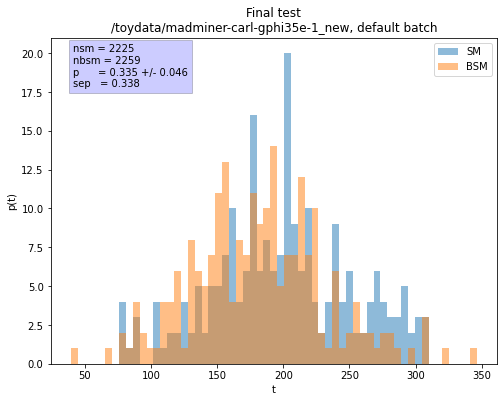

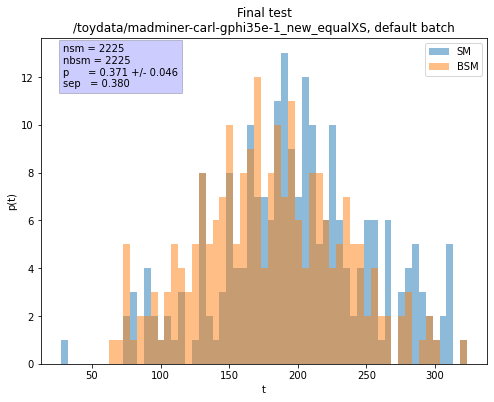

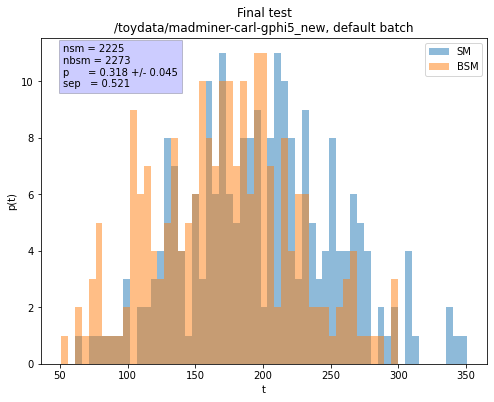

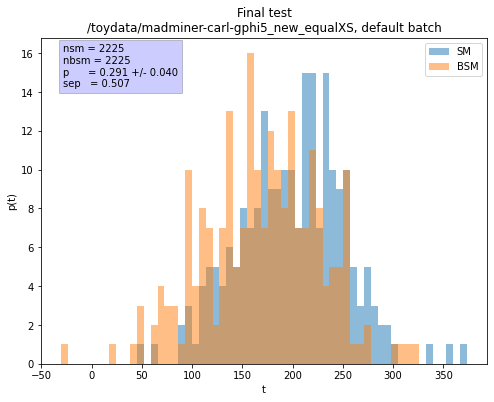

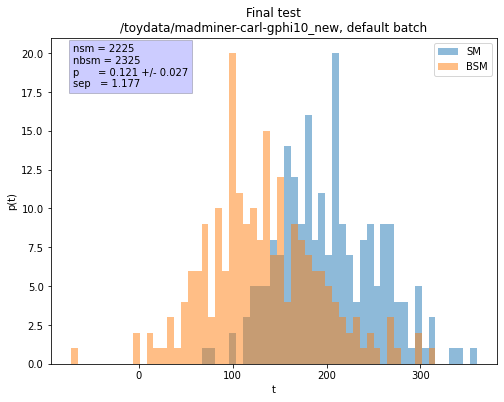

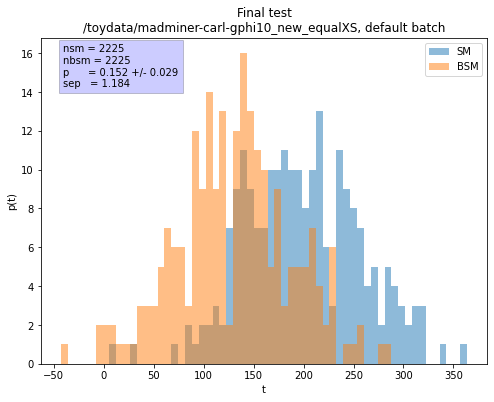

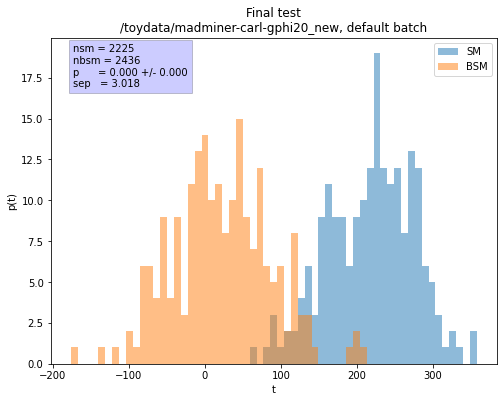

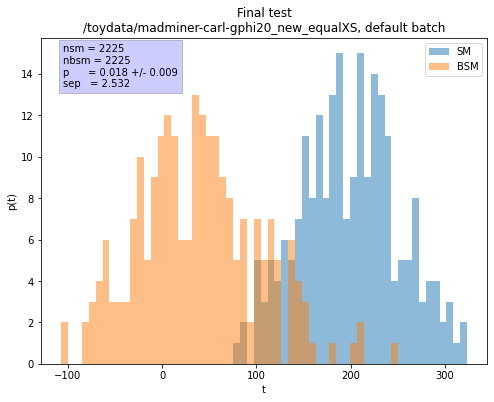

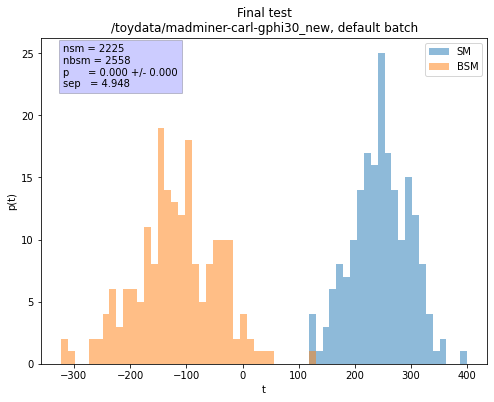

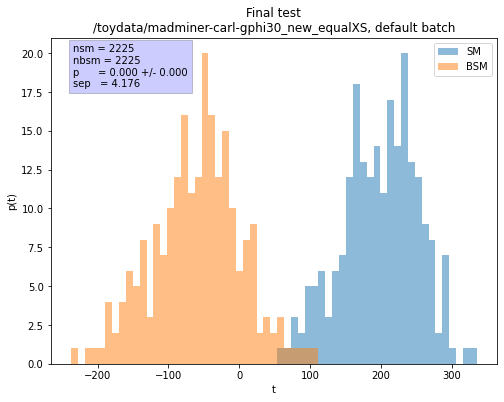

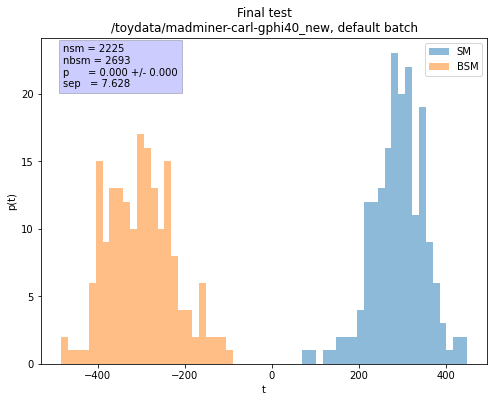

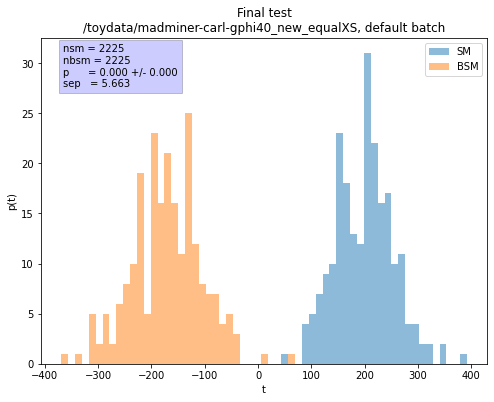

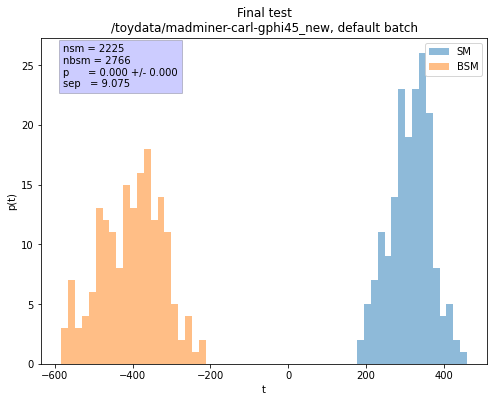

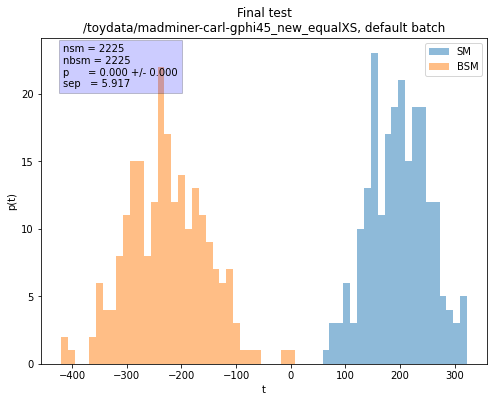

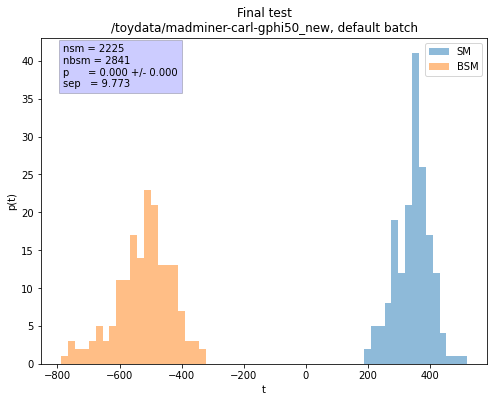

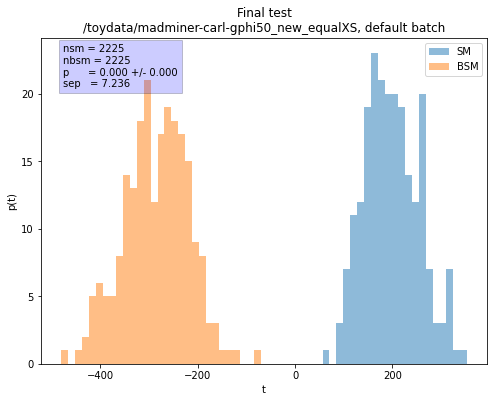

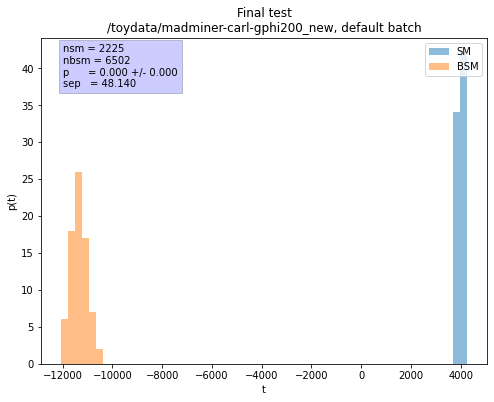

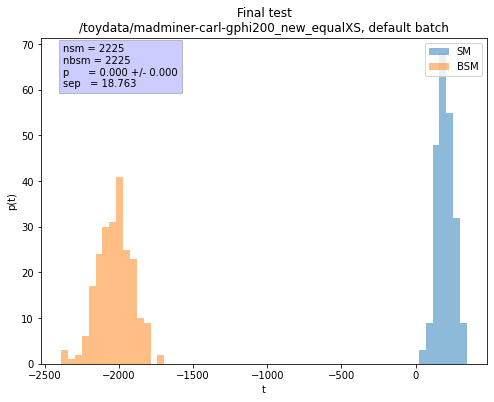

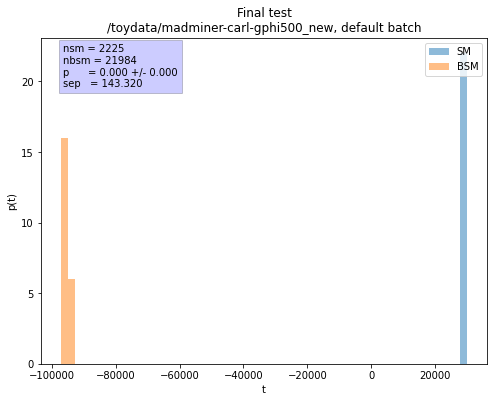

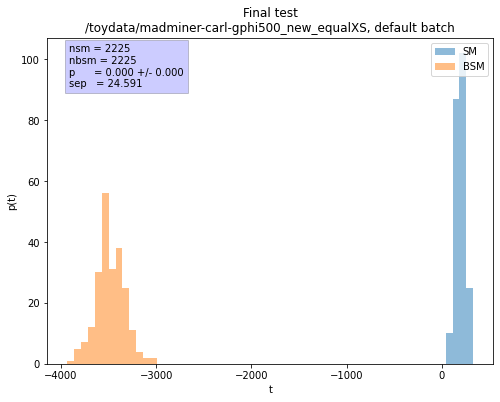

In [13]:
#Wilson coefficient value (*10^-2 TeV^-2)
gphivals = [35e-1, 5, 10, 20, 30, 40, 45, 50, 200, 500]
gphival_names = ['35e-1', '5', '10', '20', '30', '40', '45', '50', '200', '500']
seps, ps = [], []
seps_alt, ps_alt = [], []


for (gphival, gphival_name) in zip(gphivals, gphival_names):
    print('Evaluating with knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, title_message=', default batch')
    seps.append(result[0])
    ps.append(result[1])
    
    print('Evaluating without knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, withXS=False, title_message=', default batch')
    seps_alt.append(result[0])
    ps_alt.append(result[1])
    

In [14]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl1000-bigbatch')

Evaluating with knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = 181.793,  tbsm = 200.071
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.025, delta2 = 0.021
p = 0.167 +/- 0.033
Separation = 0.79 sigmas
Partial test after 10000 epochs (took 128.04 seconds)

Evaluating without knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = 213.493,  tbsm = 178.102
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.027, delta2 = 0.020
p = 0.210 +/- 0.034
Separation = 0.92 sigmas
Partial test after 10000 epochs (took 123.57 seconds)

Evaluating with knowledge on the Cross Section, gphi=5
NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 204.754,  tbsm = 188.696
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.023, delta2 = 0.014
p = 0.128 +/- 0.027
Separation = 1.21 sigmas
Partial test after 10000 epochs (took 112.96 seconds)

Evaluating without knowledge on 

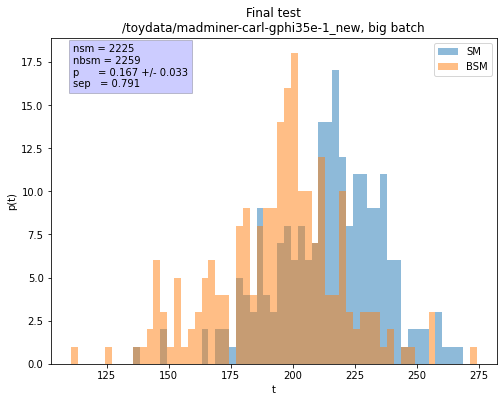

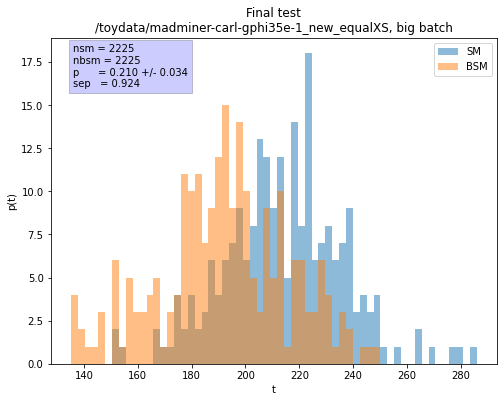

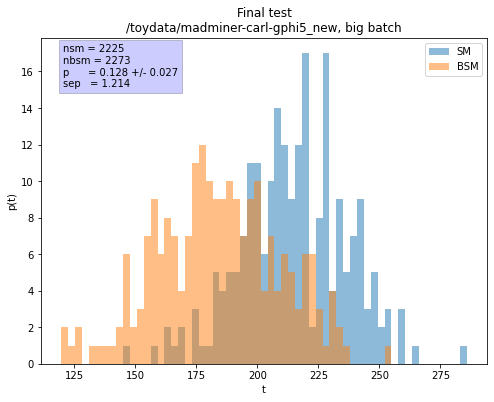

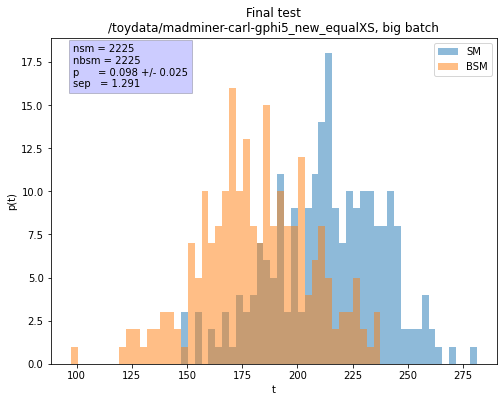

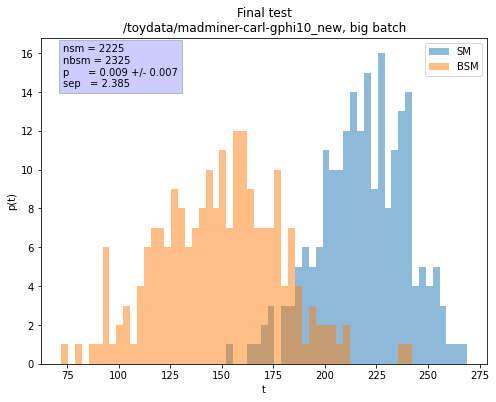

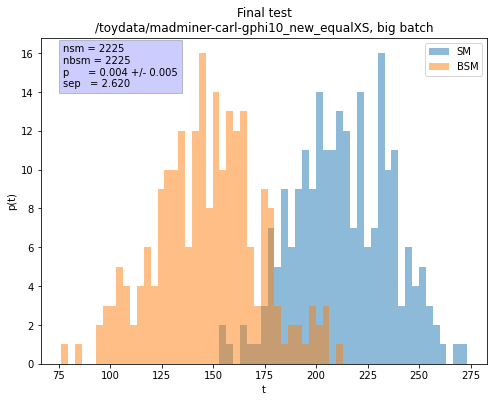

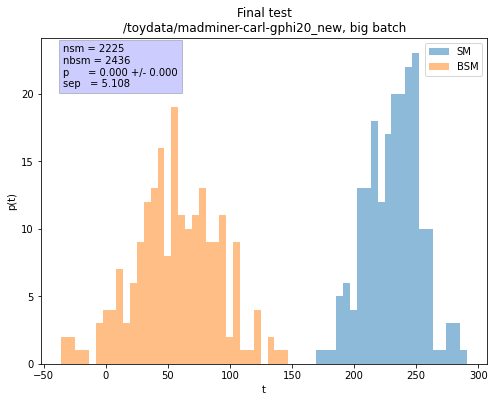

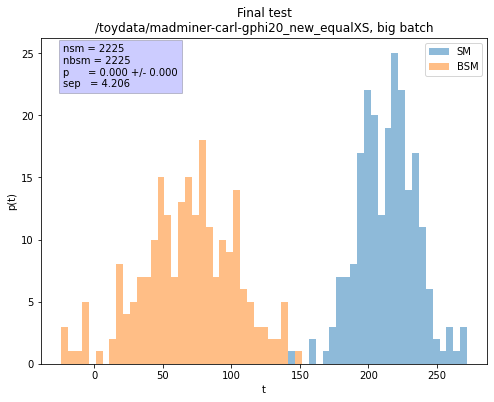

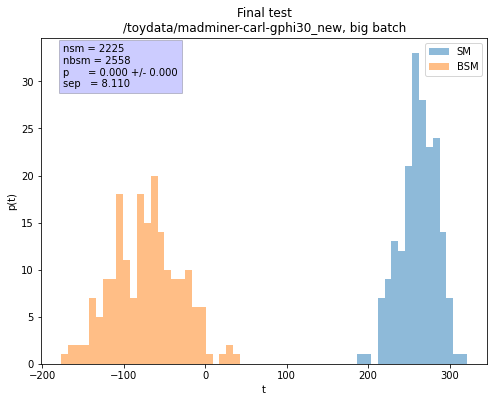

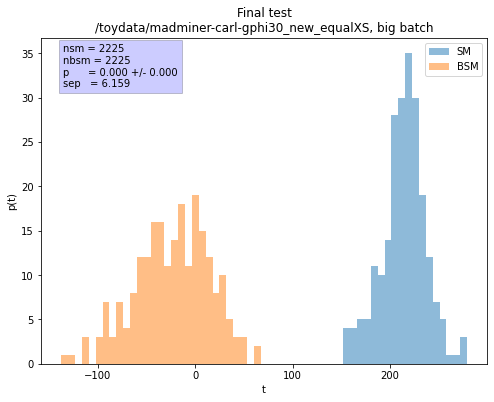

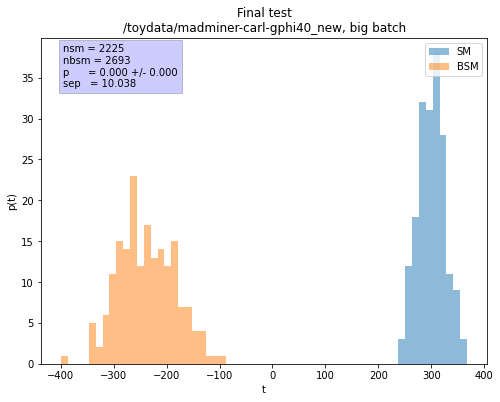

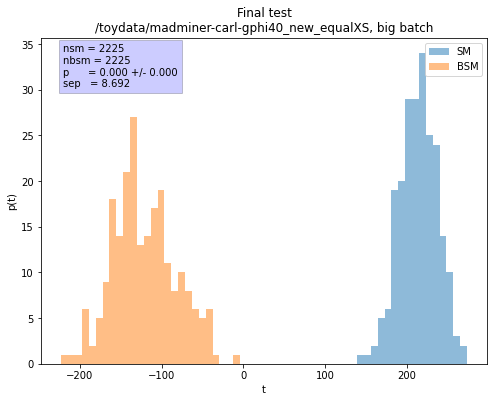

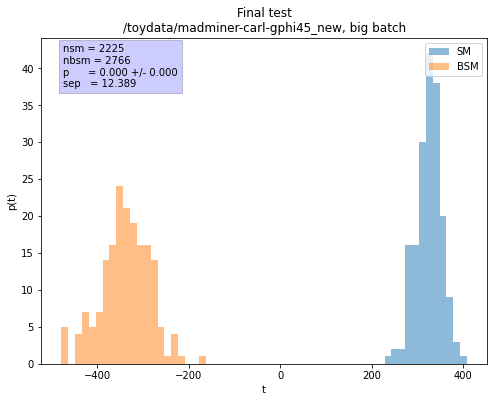

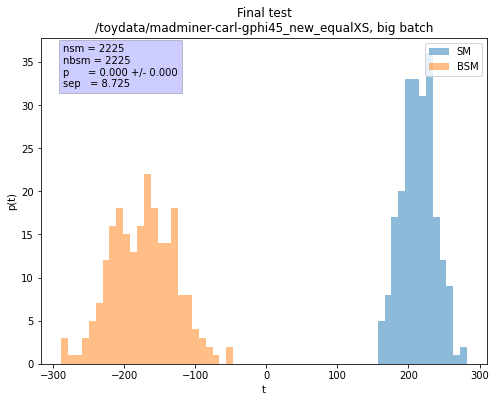

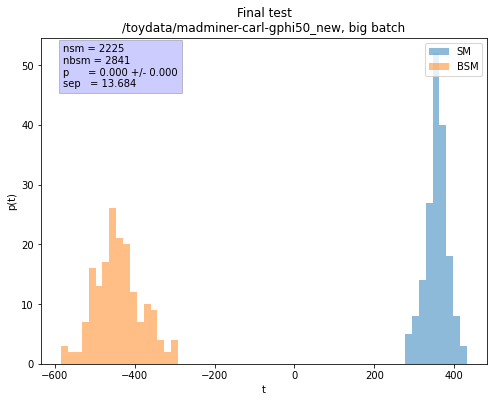

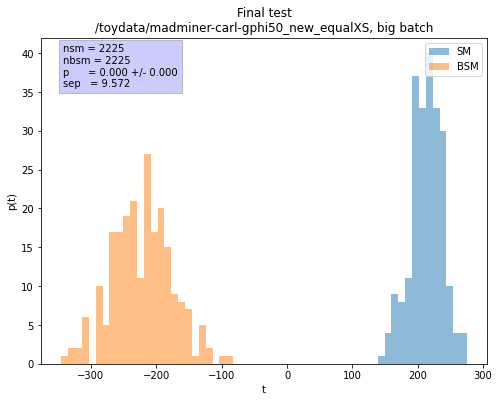

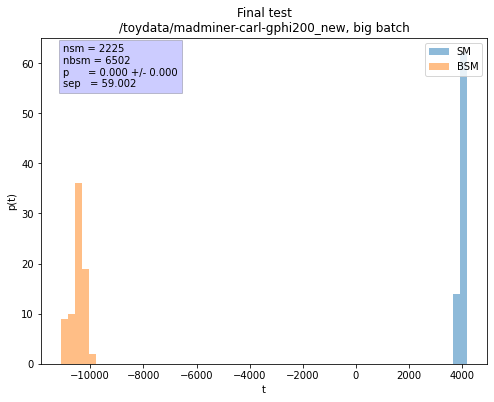

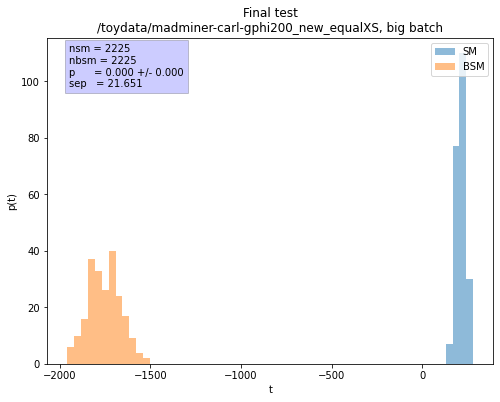

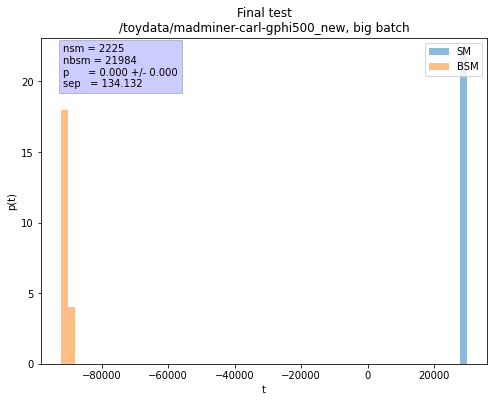

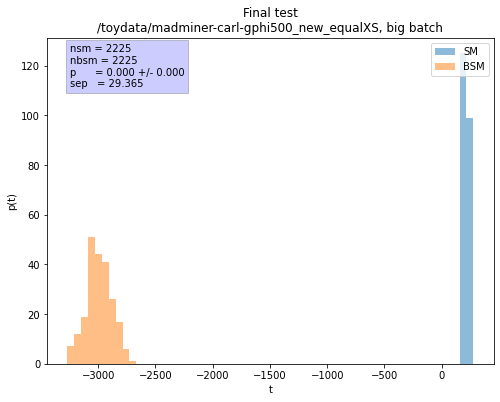

In [15]:
#Wilson coefficient value (*10^-2 TeV^-2)
gphivals = [35e-1, 5, 10, 20, 30, 40, 45, 50, 200, 500]
gphival_names = ['35e-1', '5', '10', '20', '30', '40', '45', '50', '200', '500']
seps_new, ps_new = [], []
seps_alt_new, ps_alt_new = [], []


for (gphival, gphival_name) in zip(gphivals, gphival_names):
    print('Evaluating with knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, title_message=', big batch')
    seps_new.append(result[0])
    ps_new.append(result[1])
    
    print('Evaluating without knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, withXS=False, title_message=', big batch')
    seps_alt_new.append(result[0])
    ps_alt_new.append(result[1])
    

In [16]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 148.232,  tbsm = 120.700
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.030, delta2 = 0.034
p = 0.268 +/- 0.045
Separation = 0.53 sigmas
Partial test after 10000 epochs (took 35.62 seconds)



(0.5282729730012009, 0.2681818181818182)

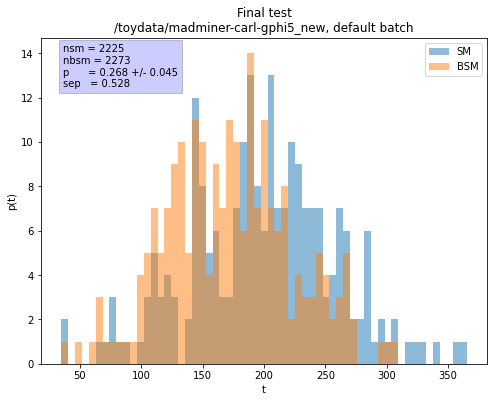

In [40]:
gphival = 10
gphival_name = '10'
withXS = True

TestEstimator(gphival, gphival_name, title_message=', default batch')

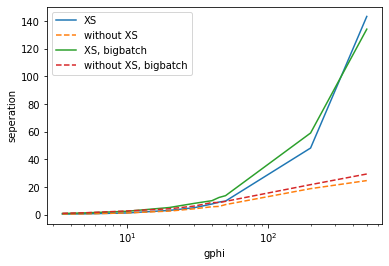

In [16]:
plt.plot(gphivals, seps, label='XS')
plt.plot(gphivals, seps_alt, '--', label='without XS')
plt.plot(gphivals, seps_new, label='XS, bigbatch')
plt.plot(gphivals, seps_alt_new, '--', label='without XS, bigbatch')
plt.xscale('log')
plt.xlabel('gphi')
plt.ylabel('seperation')
plt.legend()

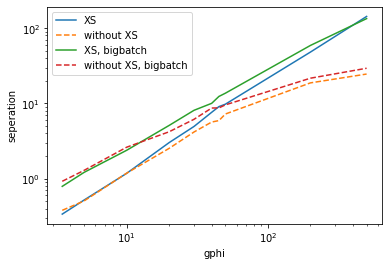

In [17]:
plt.plot(gphivals, seps, label='XS')
plt.plot(gphivals, seps_alt, '--', label='without XS')
plt.plot(gphivals, seps_new, label='XS, bigbatch')
plt.plot(gphivals, seps_alt_new, '--', label='without XS, bigbatch')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('gphi')
plt.ylabel('seperation')
plt.legend()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 380.445,  tbsm = 86.760
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 7.72 sigmas
Partial test after 10000 epochs (took 87.74 seconds)



(7.724035673387842, 0.0)

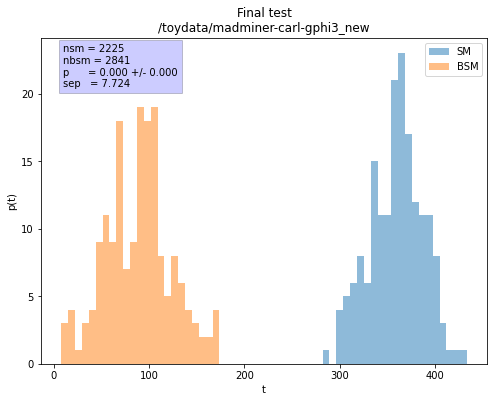

In [64]:
TestEstimator(3.5, '35e-4')

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 362.049,  tbsm = 102.786
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 8.32 sigmas
Partial test after 10000 epochs (took 87.52 seconds)



(8.321420696676606, 0.0)

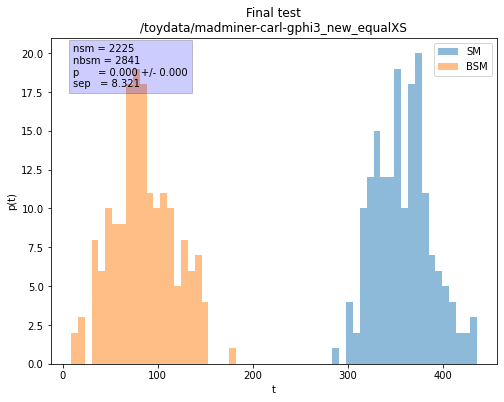

In [65]:
TestEstimator(3.5, '35e-4', False)